In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [2]:
# Load the dataset
data = pd.read_csv('matchups-2012.csv')
data.drop(['game', 'season'], axis=1, inplace=True)


In [3]:
dup_rows = data[data.duplicated()]
print("No. of duplicate rows: ", dup_rows.shape[0])

No. of duplicate rows:  0


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 home_team        0
away_team        0
starting_min     0
end_min          0
home_0           0
home_1           0
home_2           0
home_3           0
home_4           0
away_0           0
away_1           0
away_2           0
away_3           0
away_4           0
fga_home         0
fta_home         0
fgm_home         0
fga_2_home       0
fgm_2_home       0
fga_3_home       0
fgm_3_home       0
ast_home         0
blk_home         0
pf_home          0
reb_home         0
dreb_home        0
oreb_home        0
to_home          0
pts_home         0
pct_home         0
pct_2_home       0
pct_3_home       0
fga_visitor      0
fta_visitor      0
fgm_visitor      0
fga_2_visitor    0
fgm_2_visitor    0
fga_3_visitor    0
fgm_3_visitor    0
ast_visitor      0
blk_visitor      0
pf_visitor       0
reb_visitor      0
dreb_visitor     0
oreb_visitor     0
to_visitor       0
pts_visitor      0
pct_visitor      0
pct_2_visitor    0
pct_3_visitor    0
outcome          0
dtype: int64


In [5]:
class PlayerLabelEncoder:
    def __init__(self):
        self.label_mapping = {}
        self.reverse_mapping = {}
        self.last_encoded_value = 999  # Start encoding from 1000

    def fit(self, data):
        unique_labels = set(data.unique())
        for label in unique_labels:
            if label not in self.label_mapping:
                self.last_encoded_value += 1
                encoded_label = self.last_encoded_value
                self.label_mapping[label] = encoded_label
                self.reverse_mapping[encoded_label] = label
        return self

    def transform(self, data):
        return data.map(self.label_mapping).fillna(self.last_encoded_value + 1)  # Fill unseen values with new encoding

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def get_label_mapping(self):
        return self.label_mapping
    
    def get_reverse_mapping(self):
        return self.reverse_mapping
    
    def decode_label(self, encoded_value):
        return self.reverse_mapping.get(encoded_value, None)


In [6]:
player_name_columns = ['home_team', 'away_team',
                       'home_0', 'home_1', 'home_2', 'home_3', 'home_4', 
                       'away_0', 'away_1', 'away_2', 'away_3', 'away_4']

# Initialize the encoder
player_encoder = PlayerLabelEncoder()

# Fit and transform each player name column
for col in player_name_columns:
    data[col] = player_encoder.fit_transform(data[col])
data

,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,home_4,away_0,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,1024,1011,0,5,1134,1219,1242,1091,1394,1177,...,0,8,6,2,2,9,0.363636,0.375000,0.333333,1
1,1024,1011,6,6,1219,1134,1242,1236,1464,1177,...,0,1,1,0,0,5,1.000000,1.000000,1.000000,-1
2,1024,1011,7,8,1219,1134,1242,1236,1464,1278,...,0,4,3,1,1,4,0.500000,0.666667,0.000000,-1
3,1024,1011,9,10,1134,1219,1236,1370,1464,1176,...,0,2,2,0,0,4,0.500000,0.666667,0.000000,-1
4,1024,1011,11,11,1219,1252,1236,1370,1464,1176,...,0,1,1,0,0,6,1.000000,0.000000,1.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,1014,1021,38,39,1138,1287,1358,1417,1491,1266,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21237,1014,1021,40,41,1138,1287,1358,1417,1491,1266,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21238,1014,1021,42,42,1138,1070,1200,1287,1417,1266,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21239,1014,1021,43,45,1138,1200,1287,1417,1491,1266,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1


/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 23 41] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


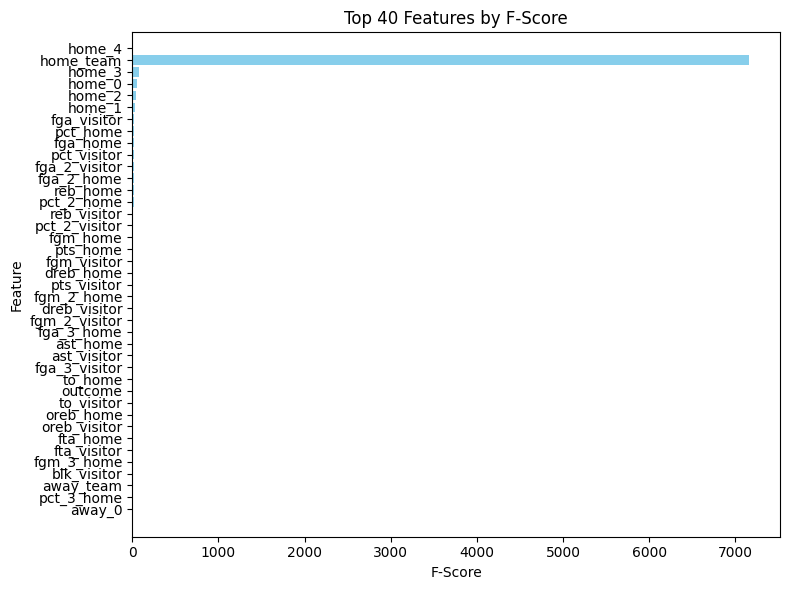

In [7]:
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# Perform ANOVA analysis
f_scores, p_values = f_classif(data, data['home_4'])

# Create a DataFrame to store feature importance scores
feature_importance = pd.DataFrame({'Feature': data.columns, 'F_Score': f_scores, 'P_Value': p_values})

# Sort features by F-score in descending order
feature_importance.sort_values(by='F_Score', ascending=False, inplace=True)

N = 40  # Number of top features to display
top_features = feature_importance.nlargest(N, 'F_Score')

plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['F_Score'], color='skyblue')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.title(f'Top {N} Features by F-Score')
plt.gca().invert_yaxis()  # Invert y-axis to display highest score at the top
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [8]:
#Skip
# Get the value counts of home_4
home_4_value_counts = data['home_4'].value_counts()

# Divide into 3 lists based on frequency
popular_players = home_4_value_counts[home_4_value_counts > 50].index.tolist()
semi_popular_players = home_4_value_counts[(home_4_value_counts >= 10) & (home_4_value_counts <= 50)].index.tolist()
rare_players = home_4_value_counts[home_4_value_counts < 10].index.tolist()

# Iterate through rare_players
for rare_player in rare_players:
    # Iterate through the dataset
    for index, row in data.iterrows():
        # Check if the rare_player is in home_4 column
        if rare_player == row['home_4']:
            # Check if any popular player is in other home columns
            for player_column in ['home_0', 'home_1', 'home_2', 'home_3']:
                if row[player_column] in popular_players:
                    # Exchange rare player with popular player in home_4
                    data.at[index, 'home_4'] = row[player_column]
                    break  # Break out of the inner loop once exchange is done


In [9]:
selected_features = ['home_team', 'away_team',
                       'home_0', 'home_1', 'home_2', 'home_3', 
                       'away_0', 'away_1', 'away_2', 'away_3', 'away_4', 'outcome', 'home_4']
# Copy selected features to another dataset
data_selected = data[selected_features].copy()
data_selected

,home_team,away_team,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,outcome,home_4
0,1024,1011,1134,1219,1242,1091,1177,1055,1298,1399,1455,1,1394
1,1024,1011,1219,1134,1242,1236,1177,1055,1298,1399,1455,-1,1464
2,1024,1011,1219,1134,1242,1236,1278,1055,1298,1399,1455,-1,1464
3,1024,1011,1134,1219,1236,1370,1176,1278,1055,1298,1455,-1,1464
4,1024,1011,1219,1252,1236,1370,1176,1278,1084,1055,1380,-1,1464
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,1014,1021,1138,1287,1358,1417,1266,1243,1274,1344,1424,-1,1491
21237,1014,1021,1138,1287,1358,1417,1266,1274,1072,1344,1424,-1,1491
21238,1014,1021,1138,1070,1200,1287,1266,1274,1072,1344,1424,-1,1417
21239,1014,1021,1138,1200,1287,1417,1266,1274,1072,1344,1424,-1,1491


In [10]:
data_selected['home_4'].value_counts()

home_4
1497    512
1477    463
1480    453
1455    436
1493    430
       ... 
1331      1
1152      1
1334      1
1115      1
1276      1
Name: count, Length: 233, dtype: int64

In [16]:
# Determine classes with less than 4 occurrences
value_counts_home_4 = data_selected['home_4'].value_counts()
classes_to_keep = value_counts_home_4[value_counts_home_4 >= 6].index

# Filter out rows with classes to keep
data_filtered = data_selected[data_selected['home_4'].isin(classes_to_keep)]

# Now, data_filtered contains only the rows where 'home_4' has at least 4 occurrences for each class.
data_filtered['home_4'].value_counts()

home_4
1497    512
1477    463
1480    453
1455    436
1493    430
       ... 
1092      7
1262      7
1200      7
1408      6
1293      6
Name: count, Length: 189, dtype: int64

In [28]:
# Split the data into features (X) and target variable (y)
y = data_filtered['home_4']
X = data_filtered.drop(columns=['home_4'])

 # Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled.value_counts()

home_4
1394    512
1435    512
1185    512
1216    512
1262    512
       ... 
1375    512
1488    512
1346    512
1456    512
1286    512
Name: count, Length: 189, dtype: int64

In [17]:
# Skip it
# Split the data into features (X) and target variable (y)
y = data_filtered['home_4']
X = data_filtered.drop(columns=['home_4'])

 # Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# # Split the resampled data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
#Baseline Random Forest Classifier 

# Train a random forest classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the performance of random forest classifier model
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
#f1_rf = f1_score(y_test, y_pred_rf)
#recall_rf = recall_score(y_test, y_pred_rf)

print("\nRandom Forest Classifier Model:")
print("Accuracy:", accuracy_rf)
#print("F1 Score:", f1_rf)
#print("Recall Score:", recall_rf)

# Generate and print the classification report
report = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report)


Random Forest Classifier Model:
Accuracy: 0.9576831662705384
Classification Report:
              precision    recall  f1-score   support

        1033       0.96      0.99      0.98       107
        1050       0.95      0.99      0.97       104
        1055       0.99      1.00      0.99        95
        1066       1.00      1.00      1.00        92
        1071       0.92      0.98      0.95       111
        1072       0.98      1.00      0.99        95
        1086       0.91      0.90      0.90       110
        1092       1.00      1.00      1.00       102
        1100       0.99      0.99      0.99        94
        1139       0.99      1.00      0.99        94
        1144       0.95      1.00      0.97        92
        1171       0.98      0.98      0.98        93
        1179       0.95      0.98      0.97       103
        1185       1.00      1.00      1.00        96
        1200       1.00      1.00      1.00        99
        1206       1.00      0.99      1.00       

In [19]:
#MLP Classifier
from sklearn.neural_network import MLPClassifier

# Define class weights
# Assuming 'class_weight' is a dictionary where keys are class labels and values are corresponding weights
class_weight = {-1: 1, 1: 5}

# Train a new DNN Classifier with selected features
dnn_classifier = MLPClassifier(random_state=42, max_iter=500)
dnn_classifier.fit(X_train_scaled, y_train)



/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=500, random_state=42)

In [20]:
# Make predictions on the test set
y_pred_mlp = dnn_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_mlp)
#f1 = f1_score(y_test, y_pred_mlp)
#recall = recall_score(y_test, y_pred_mlp)

print("\nMLP Classifier Model:")
print("Accuracy:", accuracy)
#print("F1 Score:", f1)
#print("Recall Score:", recall)

# Generate and print the classification report
report = classification_report(y_test, y_pred_mlp)
print("Classification Report:")
print(report)


MLP Classifier Model:
Accuracy: 0.8688643174537564
Classification Report:
              precision    recall  f1-score   support

        1033       0.92      0.99      0.95       107
        1050       0.88      0.78      0.83       104
        1055       0.95      1.00      0.97        95
        1066       0.98      1.00      0.99        92
        1071       0.96      0.99      0.97       111
        1072       0.96      0.97      0.96        95
        1086       0.69      0.80      0.74       110
        1092       0.97      1.00      0.99       102
        1100       0.92      0.90      0.91        94
        1139       0.96      1.00      0.98        94
        1144       0.93      1.00      0.96        92
        1171       0.99      0.97      0.98        93
        1179       0.91      1.00      0.95       103
        1185       0.97      1.00      0.98        96
        1200       1.00      1.00      1.00        99
        1206       0.98      0.99      0.99       104
      

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Creating an instance of KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Example: setting number of neighbors to 5

# Training the classifier
knn_classifier.fit(X_train_scaled, y_train)  # Assuming X_train and y_train are your training data

# Making predictions
y_pred_knn = knn_classifier.predict(X_test_scaled)  # Assuming X_test is your test data
accuracy = accuracy_score(y_test, y_pred_knn)

print("\nKNN Model:")
print("Accuracy:", accuracy)

# Generate and print the classification report
report = classification_report(y_test, y_pred_knn)
print("Classification Report:")
print(report)


KNN Model:
Accuracy: 0.8108401364059109
Classification Report:
              precision    recall  f1-score   support

        1033       0.86      1.00      0.93       107
        1050       0.74      0.81      0.77       104
        1055       0.97      0.99      0.98        95
        1066       0.89      1.00      0.94        92
        1071       0.86      0.96      0.91       111
        1072       0.90      1.00      0.95        95
        1086       0.72      0.89      0.80       110
        1092       0.90      0.99      0.94       102
        1100       0.79      0.97      0.87        94
        1139       0.90      1.00      0.95        94
        1144       0.90      0.99      0.94        92
        1171       0.84      0.89      0.86        93
        1179       0.92      0.99      0.95       103
        1185       0.95      0.98      0.96        96
        1200       0.99      1.00      0.99        99
        1206       0.89      0.98      0.93       104
        1216     

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Creating an instance of DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)  # Example: setting random_state for reproducibility

# Training the classifier
decision_tree_classifier.fit(X_train_scaled, y_train)  # Assuming X_train_scaled and y_train are your scaled training data

# Making predictions
y_pred_decision_tree = decision_tree_classifier.predict(X_test_scaled)  # Assuming X_test_scaled is your scaled test data
accuracy = accuracy_score(y_test, y_pred_decision_tree)

print("\nKNN Model:")
print("Accuracy:", accuracy)

# Generate and print the classification report
report = classification_report(y_test, y_pred_decision_tree)
print("Classification Report:")
print(report)


KNN Model:
Accuracy: 0.9031208019014157
Classification Report:
              precision    recall  f1-score   support

        1033       0.95      0.98      0.96       107
        1050       0.90      0.91      0.91       104
        1055       0.99      0.99      0.99        95
        1066       0.97      1.00      0.98        92
        1071       0.91      0.93      0.92       111
        1072       0.95      0.99      0.97        95
        1086       0.79      0.75      0.77       110
        1092       0.98      0.98      0.98       102
        1100       0.93      0.84      0.88        94
        1139       1.00      0.96      0.98        94
        1144       0.95      1.00      0.97        92
        1171       0.96      0.96      0.96        93
        1179       0.86      0.95      0.90       103
        1185       1.00      0.99      0.99        96
        1200       1.00      1.00      1.00        99
        1206       0.99      0.98      0.99       104
        1216     

In [23]:
# Load the real dataset
real_data = pd.read_csv('test.csv')
real_data

,game,season,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,200612290WAS,2007,WAS,ORL,39,41,Antawn Jamison,Antonio Daniels,Calvin Booth,Gilbert Arenas,...,1,1,1,0,0,4,1.000000,1.000000,0,1
1,200612300MIL,2007,MIL,WAS,5,6,Andrew Bogut,Brian Skinner,Charlie Bell,Michael Redd,...,1,2,2,0,0,2,0.200000,0.333333,0,1
2,200612300MIL,2007,MIL,WAS,15,17,Andrew Bogut,Michael Redd,Mo Williams,Ruben Patterson,...,1,5,4,1,1,4,0.333333,0.666667,0,1
3,200612300MIL,2007,MIL,WAS,18,21,Andrew Bogut,Michael Redd,Mo Williams,Ruben Patterson,...,0,5,5,0,3,4,0.400000,0.500000,0,1
4,200612300MIL,2007,MIL,WAS,25,28,Andrew Bogut,Brian Skinner,Charlie Bell,Michael Redd,...,1,2,1,1,1,8,0.400000,0.400000,0,1
5,200612300MIL,2007,MIL,WAS,36,36,Andrew Bogut,Charlie Bell,Michael Redd,Ruben Patterson,...,0,0,0,0,0,0,0.000000,0.000000,0,1
6,200612300MIL,2007,MIL,WAS,37,39,Brian Skinner,Charlie Bell,Michael Redd,Ruben Patterson,...,0,3,2,1,2,2,0.200000,0.200000,0,1
7,200612300MIL,2007,MIL,WAS,40,41,Brian Skinner,Charlie Bell,Michael Redd,Ruben Patterson,...,0,2,0,2,0,2,0.333333,0.333333,0,1
8,200612300MIL,2007,MIL,WAS,42,42,Brian Skinner,Charlie Bell,Michael Redd,Mo Williams,...,0,0,0,0,0,0,0.000000,0.000000,0,1
9,200612300MIL,2007,MIL,WAS,43,44,Brian Skinner,Charlie Bell,Michael Redd,Mo Williams,...,0,2,0,2,0,6,0.500000,0.500000,0,1


In [24]:

# Select only the features selected during training
real_data_selected = real_data[selected_features[:-1]]  # Exclude the target variable 'outcome'
# Use the same mapping for new data
for col in player_name_columns:
    if col in real_data_selected.columns:
        real_data_selected.loc[:, col] = player_encoder.transform(real_data_selected[col]).astype(int)


# for col, encoder in label_encoders.items():
#     if col in real_data_selected.columns:
#         # Handle unseen labels gracefully by skipping rows containing them
#         real_data_selected = real_data_selected[real_data_selected[col].isin(encoder.classes_)]
#         real_data_selected[col] = encoder.transform(real_data_selected[col])
real_data_selected

,home_team,away_team,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,outcome
0,1018,1013,1199,1507,1507,1045,1507,1122,1353,1342,1460,1
1,1022,1018,1106,1504,1507,1322,1199,1507,1077,1096,1045,1
2,1022,1018,1106,1322,1086,1507,1141,1507,1507,1077,1507,1
3,1022,1018,1106,1322,1086,1507,1141,1199,1096,1045,1507,1
4,1022,1018,1106,1504,1507,1322,1199,1507,1077,1096,1045,1
5,1022,1018,1106,1507,1322,1507,1507,1507,1077,1045,1507,1
6,1022,1018,1504,1507,1322,1507,1507,1507,1077,1045,1507,1
7,1022,1018,1504,1507,1322,1507,1199,1507,1077,1096,1045,1
8,1022,1018,1504,1507,1322,1086,1199,1507,1077,1096,1045,1
9,1022,1018,1504,1507,1322,1086,1199,1077,1096,1045,1507,1


In [26]:
# Scale the features using the same scaler
X_real_scaled = scaler.transform(real_data_selected)

# Make predictions on the real data using the trained random forest classifier
y_pred_real = rf_model.predict(X_real_scaled)

# Print the predictions
print("Predictions on real data encoded:", y_pred_real)

# Print the decoded predictions in one line with commas and spaces between names
print("Predictions on real data decoded:", ", ".join(player_encoder.decode_label(prediction) for prediction in y_pred_real))



Predictions on real data encoded: [1495 1502 1499 1499 1502 1499 1450 1450 1139 1326 1139]
Predictions on real data decoded: Sundiata Gaines, Tobias Harris, Raja Bell, Raja Bell, Tobias Harris, Raja Bell, Linas Kleiza, Linas Kleiza, Gary Forbes, Jose Calderon, Gary Forbes


In [27]:
# Scale the features using the same scaler
X_real_scaled = scaler.transform(real_data_selected)

# Make predictions on the real data using the trained random forest classifier
y_pred_real = dnn_classifier.predict(X_real_scaled)

# Print the predictions
print("Predictions on real data:", y_pred_real)

# Print the decoded predictions in one line with commas and spaces between names
print("Predictions on real data:", ", ".join(player_encoder.decode_label(prediction) for prediction in y_pred_real))


# # Print the decoded predictions
# print("Predictions on real data:")
# for prediction in y_pred_real:
#     print(player_encoder.decode_label(prediction))

Predictions on real data: [1490 1066 1441 1441 1066 1441 1441 1485 1485 1139 1485]
Predictions on real data: Trevor Booker, DeMar DeRozan, Shannon Brown, Shannon Brown, DeMar DeRozan, Shannon Brown, Shannon Brown, Xavier Henry, Xavier Henry, Gary Forbes, Xavier Henry
